###  Plot data preparation of C/m5C/hm5C

In [1]:
#python code

from scipy import interpolate
import traceback
import pandas as pd
import re
import numpy as np
from statsmodels import robust


def interp(x):
    """
    Interpolates a given list of values using linear interpolation.

    Args:
        x (list): List of values to be interpolated.

    Returns:
        list: Interpolated values.

    """
    l=len(x)
    y=x
    x=np.linspace(0,l-1,l)
    f=interpolate.interp1d(x,y,kind='slinear')
    x_new=np.linspace(0,l-1,100)
    y_new=f(x_new)
    y_new=np.around(y_new,4)
    return y_new.tolist()

ref_file="/home/wuyou/Projects/paper/data/ELIGOS.fasta"
ref_dict={}

with open(ref_file) as f:
    for line in f:
        line=line.rstrip()
        if ">" in line:
            chr=line[1:]
        else:
            seq=line
            ref_dict[chr]=seq

ref_chr="C2"
site=151

normalize="median_mad"

motif=ref_dict[chr][site-2:site+3]

print("motif:", motif)

X_mean=[]
X_std=[]
X_median=[]
X_length=[]
X_base_quality=[]
Y=[]

signal_files=["/home/wuyou/Projects/paper/ELIGOS_normalC/normalC.signal.tsv",
              "/home/wuyou/Projects/paper/ELIGOS_m5C/m5C.signal.tsv",
             "/home/wuyou/Projects/paper/ELIGOS_hm5C/hm5C.signal.tsv"]

label_dict={0:"C",1:"m5C",2:"hm5C"}

for k,signal_file in enumerate(signal_files):
    with open(signal_file) as f:
        count=0
        for line in f:
            line=line.rstrip()
            chr=line.split("\t")[1]
            start=int(line.split("\t")[2])
            seq=line.split("\t")[3]
            signal_string=line.split("\t")[6]
            base_quality_list=line.split("\t")[4].split("|")
            raw_signal=[base_signal_string.split("*") for base_signal_string in signal_string.split("|")]  

            full_length_signal=np.array([x for x in re.split('\*|\|',signal_string)],dtype=int)   #for normlization
            uniq_arr=np.unique(full_length_signal)
            full_length_mean=np.mean(full_length_signal)
            full_length_std=np.std(full_length_signal)



            if start > site or start+len(seq)-3<site or chr != ref_chr:
                continue
            kmer_raw_signal=raw_signal[site-(start-1)-2:site-(start-1)+3]
            kmer_sequence=seq[site-(start-1)-2:site-(start-1)+3]
            if len(kmer_raw_signal)==0:
                continue
            kmer_raw_signal=[np.array(x,dtype=float) for x in kmer_raw_signal]

            if normalize=="zscore":  
                kmer_raw_signal=[(x-full_length_mean)/full_length_std for x in kmer_raw_signal]     #z-score scaling
            elif normalize=="median_mad":  
                kmer_raw_signal = [(x - np.median(uniq_arr)) / float(robust.mad(uniq_arr)) for x in kmer_raw_signal]

            mean=[np.round(np.mean(x),3) for x in kmer_raw_signal]
            std=[np.round(np.std(x),3) for x in kmer_raw_signal]
            median=[np.round(np.median(x),3) for x in kmer_raw_signal]
            length=[len(x) for x in kmer_raw_signal]
            kmer_base_quality=base_quality_list[site-(start-1)-2:site-(start-1)+3]


            x=[]

            if len(kmer_raw_signal) != 5:
                continue

            for i in range(5):      #resample to 500 points

                kmer_raw_signal[i]=interp(np.array(kmer_raw_signal[i],dtype=float))
                x.extend(kmer_raw_signal[i])
            X_mean.append(mean)
            X_std.append(std)
            X_median.append(median)
            X_length.append(length)
            X_base_quality.append(kmer_base_quality)
            Y.append(label_dict[k])
            count+=1
            if count>100:
                break
            

print("data length:",len(Y))

#save data
data=X_mean
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   

data["label"]=Y
data["sequence"]=[motif]*len(Y)
data=pd.melt(data,id_vars=["label","sequence"])
data.to_csv("data/event_level_features_C_mean.csv")

data=X_std
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   

data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_C_std.csv")

data=X_median
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   

data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_C_median.csv")

data=X_length
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   

data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_C_length.csv")

data=X_base_quality
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   

data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_C_base_quality.csv")

motif: AACGG
data length: 303


### Boxplot of of C/m5C/hm5C

Registering fonts with R



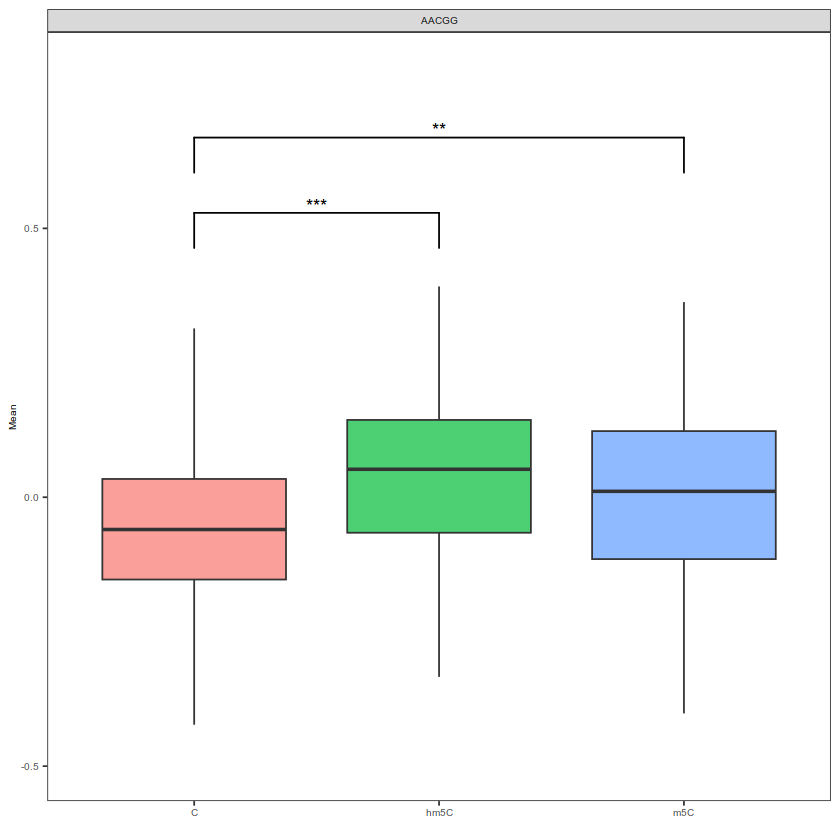

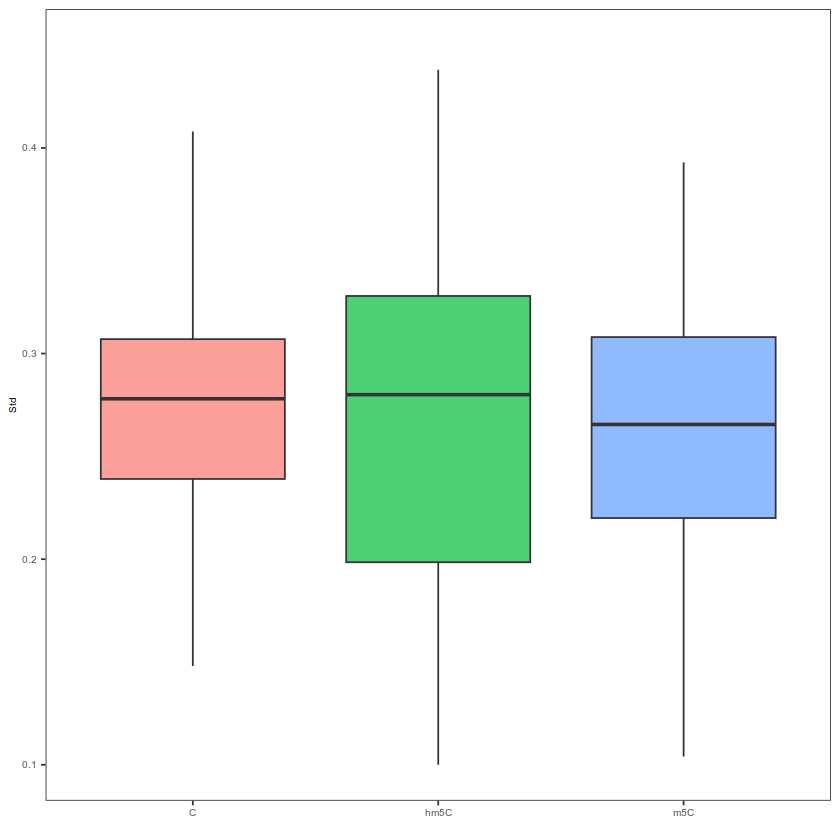

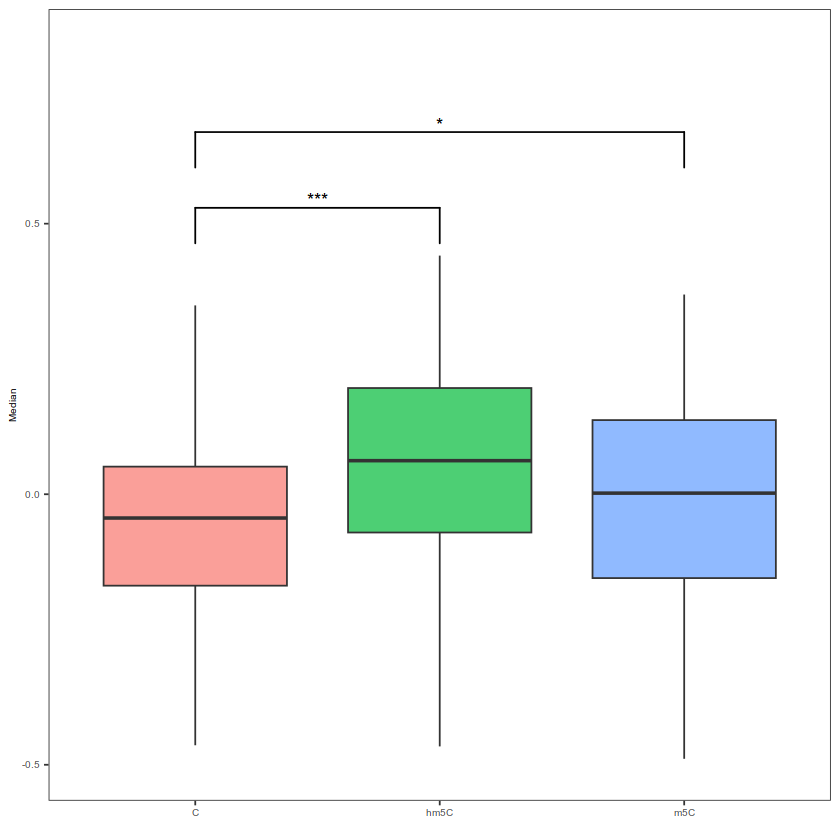

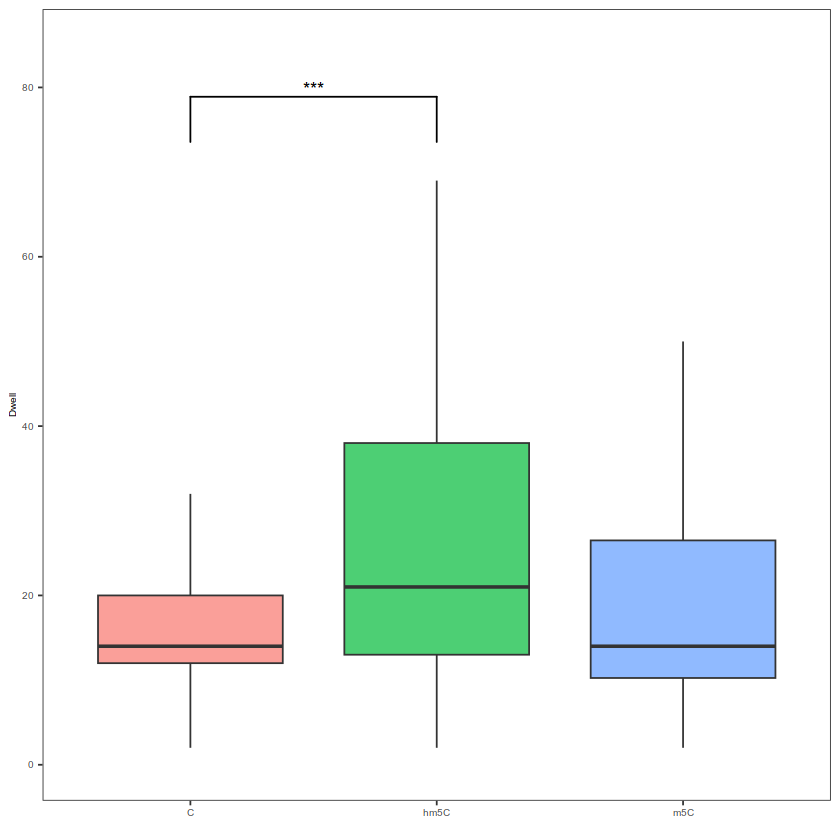

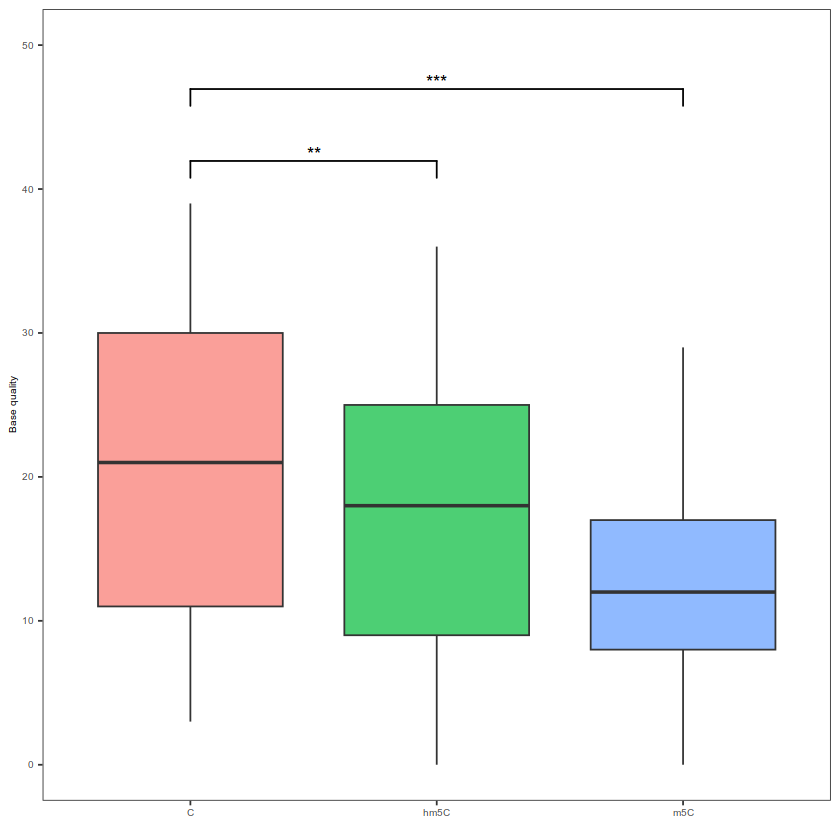

In [1]:
#R code, event level features


library(ggplot2)
library(ggsignif)
library(extrafont)
options(warn = -1)

#mean
data=read.csv("data/event_level_features_C_mean.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("C", "m5C")),
        map_signif_level = TRUE,
        y_position =0.56,vjust = 0.5
      )+
    geom_signif(
        comparisons = list(c("C", "hm5C")),
        map_signif_level = TRUE,
        y_position = 0.42,vjust = 0.5
    )+
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "Mean",x = "")+
      ylim(c(-0.5,0.8))+
      facet_wrap(vars(sequence))
        
ggsave("figure/figure_1a_event_level_features_C_mean.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)


#std
data=read.csv("data/event_level_features_C_std.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "Std",x = "")+
      ylim(c(0.1,0.45))
      #facet_wrap(vars(sequence))
        
ggsave("figure/figure_1a_event_level_features_C_std.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)


#median
data=read.csv("data/event_level_features_C_median.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("C", "m5C")),
        map_signif_level = TRUE,
        y_position =0.56,vjust = 0.5
      )+
    geom_signif(
        comparisons = list(c("C", "hm5C")),
        map_signif_level = TRUE,
        y_position = 0.42,vjust = 0.5
    )+
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "Median",x = "")+
      ylim(c(-0.5,0.83))
      #facet_wrap(vars(sequence))
        
ggsave("figure/figure_1a_event_level_features_C_median.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)


#dwell
data=read.csv("data/event_level_features_C_length.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+

    geom_signif(
        comparisons = list(c("C", "hm5C")),
        map_signif_level = TRUE,
        y_position = 70,vjust = 0.5
    )+
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "Dwell",x = "")+
      ylim(c(0,85))
      #facet_wrap(vars(sequence))
        
ggsave("figure/figure_1a_event_level_features_C_length.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)



#base quality
data=read.csv("data/event_level_features_C_base_quality.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+

    geom_signif(
        comparisons = list(c("C", "hm5C")),
        map_signif_level = TRUE,
        y_position = 40,vjust = 0.5
    )+
    geom_signif(
        comparisons = list(c("C", "m5C")),
        map_signif_level = TRUE,
        y_position = 45,vjust = 0.5
    )+
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "Base quality",x = "")+
      ylim(c(0,50))
      #facet_wrap(vars(sequence))
        
ggsave("figure/figure_1a_event_level_features_C_base_quality.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)

### Data preparation of A/m1A/m6A

In [2]:
#python code

from scipy import interpolate
import traceback
import pandas as pd
import re
import numpy as np
from statsmodels import robust


def interp(x):
    """
    Interpolates a given list of values using linear interpolation.

    Args:
        x (list): List of values to be interpolated.

    Returns:
        list: Interpolated values.

    """
    l=len(x)
    y=x
    x=np.linspace(0,l-1,l)
    f=interpolate.interp1d(x,y,kind='slinear')
    x_new=np.linspace(0,l-1,100)
    y_new=f(x_new)
    y_new=np.around(y_new,4)
    return y_new.tolist()

ref_file="/home/wuyou/Projects/paper/data/ELIGOS.fasta"
ref_dict={}
with open(ref_file) as f:
    for line in f:
        line=line.rstrip()
        if ">" in line:
            chr=line[1:]
        else:
            seq=line
            ref_dict[chr]=seq


ref_chr="A1"
site=159

normalize="median_mad"

motif=ref_dict[chr][site-2:site+3]
print("motif:",motif)

X_mean=[]
X_std=[]
X_median=[]
X_length=[]
X_base_quality=[]
Y=[]

signal_files=["/home/wuyou/Projects/paper/ELIGOS_normalA/normalA.signal.tsv",
              "/home/wuyou/Projects/paper/ELIGOS_m1A/m1A.signal.tsv",
             "/home/wuyou/Projects/paper/ELIGOS_m6A/m6A.signal.tsv"]

label_dict={0:"A",1:"m1A",2:"m6A"}

for k,signal_file in enumerate(signal_files):
    with open(signal_file) as f:
        count=0
        for line in f:
            line=line.rstrip()
            chr=line.split("\t")[1]
            start=int(line.split("\t")[2])
            seq=line.split("\t")[3]
            signal_string=line.split("\t")[6]
            base_quality_list=line.split("\t")[4].split("|")
            raw_signal=[base_signal_string.split("*") for base_signal_string in signal_string.split("|")]  

            full_length_signal=np.array([x for x in re.split('\*|\|',signal_string)],dtype=int)   #for normlization
            uniq_arr=np.unique(full_length_signal)
            full_length_mean=np.mean(full_length_signal)
            full_length_std=np.std(full_length_signal)

            if start > site or start+len(seq)-3<site or chr != ref_chr:
                continue
            kmer_raw_signal=raw_signal[site-(start-1)-2:site-(start-1)+3]
            kmer_sequence=seq[site-(start-1)-2:site-(start-1)+3]
            if len(kmer_raw_signal)==0:
                continue
            kmer_raw_signal=[np.array(x,dtype=float) for x in kmer_raw_signal]

            if normalize=="zscore":  
                kmer_raw_signal=[(x-full_length_mean)/full_length_std for x in kmer_raw_signal]     #z-score scaling
            elif normalize=="median_mad":  
                kmer_raw_signal = [(x - np.median(uniq_arr)) / float(robust.mad(uniq_arr)) for x in kmer_raw_signal]

            mean=[np.round(np.mean(x),3) for x in kmer_raw_signal]
            std=[np.round(np.std(x),3) for x in kmer_raw_signal]
            median=[np.round(np.median(x),3) for x in kmer_raw_signal]
            length=[len(x) for x in kmer_raw_signal]
            kmer_base_quality=base_quality_list[site-(start-1)-2:site-(start-1)+3]

            x=[]

            if len(kmer_raw_signal) != 5:
                continue

            for i in range(5):       #resample to 500 points

                kmer_raw_signal[i]=interp(np.array(kmer_raw_signal[i],dtype=float))
                x.extend(kmer_raw_signal[i])
            X_mean.append(mean)
            X_std.append(std)
            X_median.append(median)
            for i in range(len(length)):
                if length[i]>100:
                    length[i]=100
            X_length.append(length)
            X_base_quality.append(kmer_base_quality)
            Y.append(label_dict[k])
            count+=1
            if count>100:
                break
            
print("data length:",len(Y))

#save data
data=X_mean
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data["sequence"]=[motif]*len(Y)
data=pd.melt(data,id_vars=["label","sequence"])
data.to_csv("data/event_level_features_A_mean.csv")

data=X_std
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_A_std.csv")

data=X_median
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_A_median.csv")

data=X_length
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_A_length.csv")

data=X_base_quality
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_A_base_quality.csv")                    

motif: GGACA
data length: 303


### Boxplot of of A/m1A/m6A

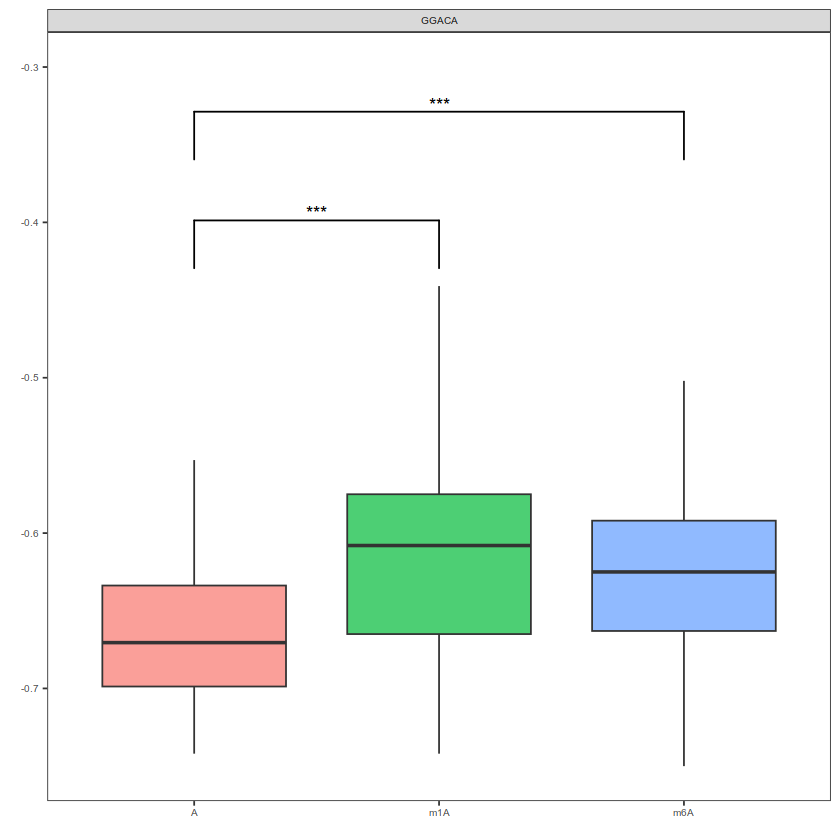

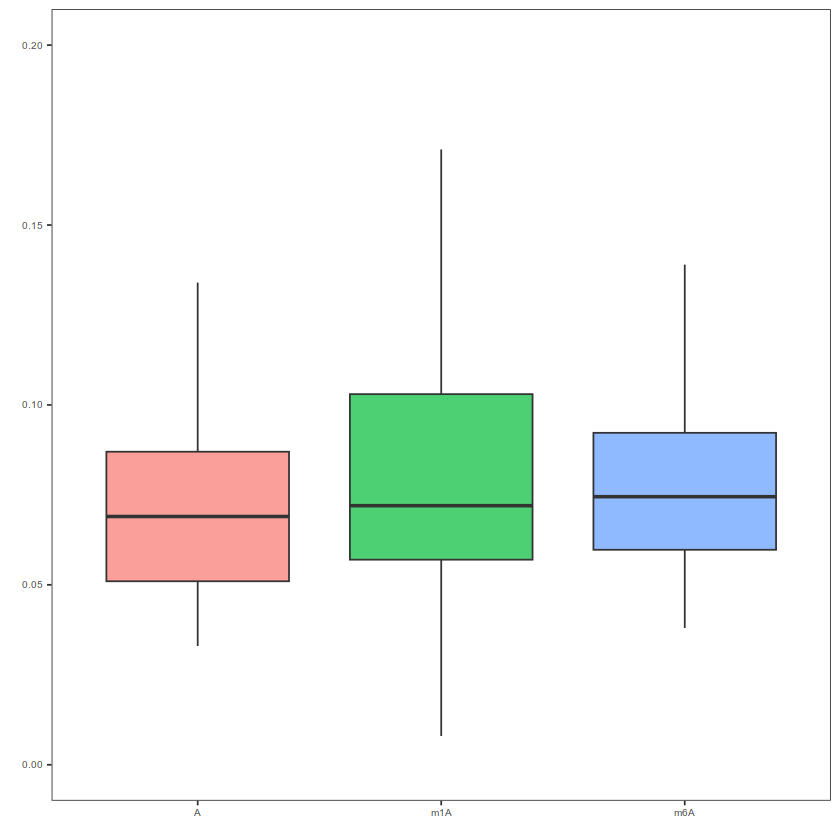

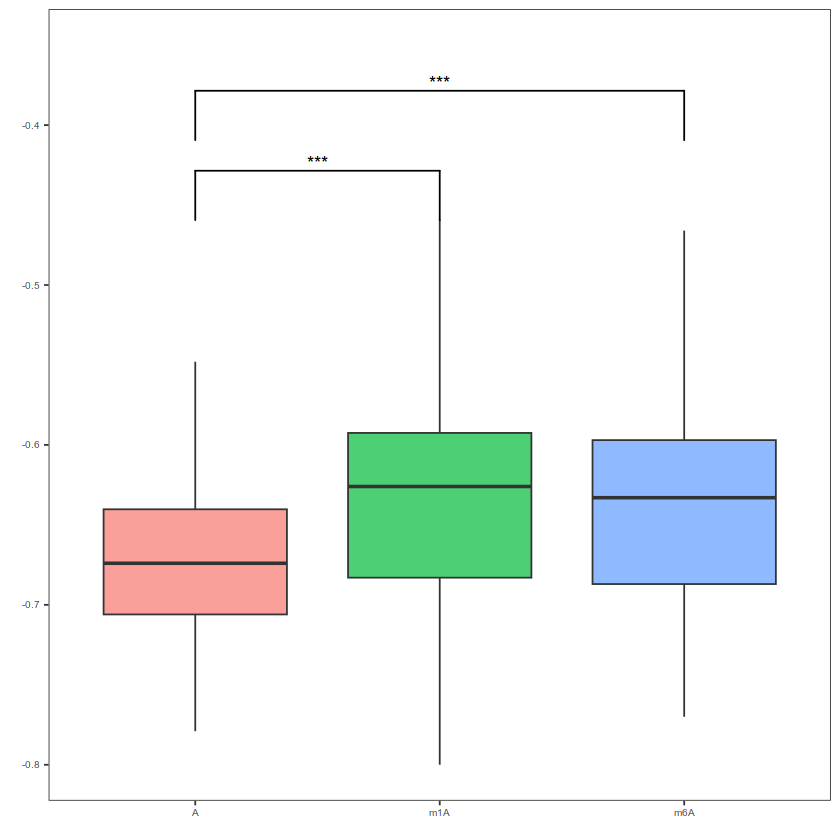

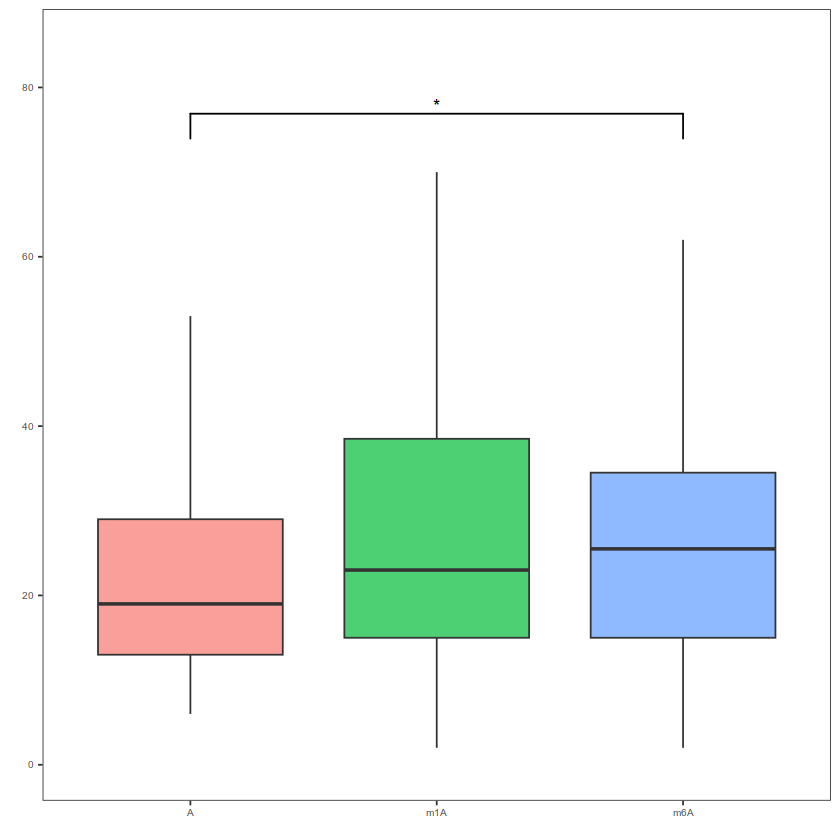

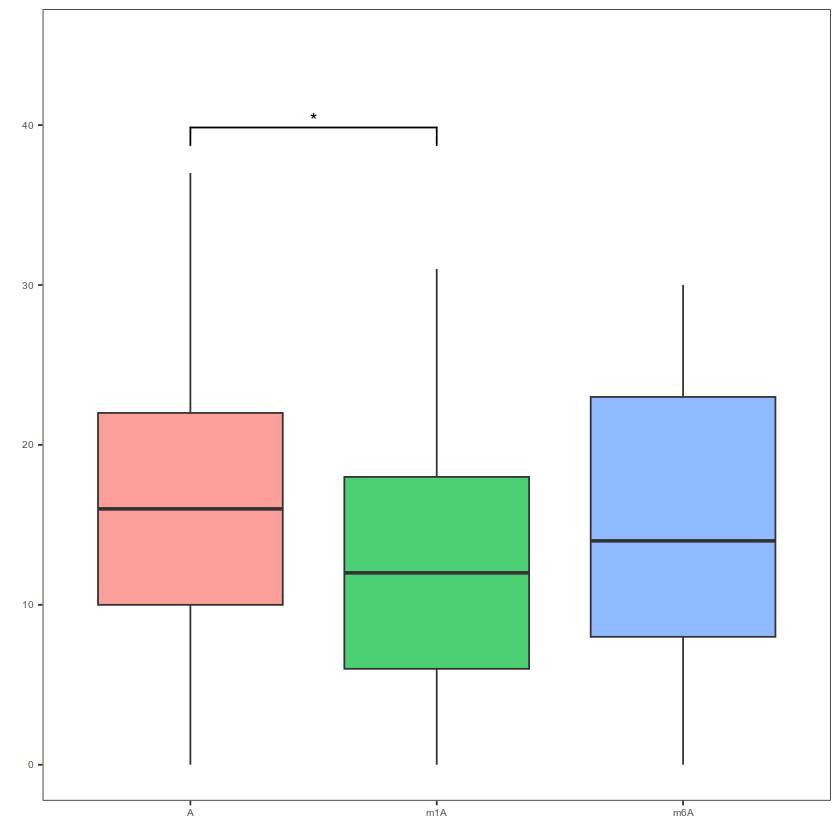

In [2]:
#R code
#event level features

library(ggplot2)
library(ggsignif)
library(extrafont)
options(warn = -1)


#mean
data=read.csv("data/event_level_features_A_mean.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("A", "m1A")),
        map_signif_level = TRUE,
        y_position = -0.45,vjust = 0.5
      )+
    geom_signif(
        comparisons = list(c("A", "m6A")),
        map_signif_level = TRUE,
        y_position = -0.38,vjust = 0.5
    )+
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(-0.75,-0.3))+
      facet_wrap(vars(sequence))
        
ggsave("figure/figure_1a_event_level_features_A_mean.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)



#std
data=read.csv("data/event_level_features_A_std.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(0,0.20))
      #facet_wrap(vars(sequence))
        
ggsave("figure/figure_1a_event_level_features_A_std.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)



#median
data=read.csv("data/event_level_features_A_median.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("A", "m1A")),
        map_signif_level = TRUE,
        y_position = -0.48,vjust = 0.5
      )+
    geom_signif(
        comparisons = list(c("A", "m6A")),
        map_signif_level = TRUE,
        y_position = -0.43,vjust = 0.5
    )+
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(-0.8,-0.35))
      #facet_wrap(vars(sequence))
        
ggsave("figure/figure_1a_event_level_features_A_median.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)



#dwell
data=read.csv("data/event_level_features_A_length.csv", encoding='utf-8')


ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+

    geom_signif(
        comparisons = list(c("A", "m6A")),
        map_signif_level = TRUE,
        y_position = 72,vjust = 0.5
    )+
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y ="",x = "")+
      ylim(c(0,85))
      #facet_wrap(vars(sequence))
        
ggsave("figure/figure_1a_event_level_features_A_length.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)




#base_quality
data=read.csv("data/event_level_features_A_base_quality.csv", encoding='utf-8')


ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("A", "m1A")),
        map_signif_level = TRUE,
        y_position = 38,vjust = 0.5
    )+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y ="",x = "")+
      ylim(c(0,45))
      #facet_wrap(vars(sequence))
        
ggsave("figure/figure_1a_event_level_features_A_base_quality.pdf", width = 4, height = 3.4, units = "cm",device = 'pdf', dpi = 600)


### Plot data preparation of G/m7G

In [2]:
#python code

from scipy import interpolate
import traceback
import pandas as pd
import re
import numpy as np
from statsmodels import robust

def interp(x):
    """
    Interpolates a given list of values using linear interpolation.

    Args:
        x (list): List of values to be interpolated.

    Returns:
        list: Interpolated values.

    """
    l=len(x)
    y=x
    x=np.linspace(0,l-1,l)
    f=interpolate.interp1d(x,y,kind='slinear')
    x_new=np.linspace(0,l-1,100)
    y_new=f(x_new)
    y_new=np.around(y_new,4)
    return y_new.tolist()

ref_file="/home/wuyou/Projects/paper/data/ELIGOS.fasta"
ref_dict={}
with open(ref_file) as f:
    for line in f:
        line=line.rstrip()
        if ">" in line:
            chr=line[1:]
        else:
            seq=line
            ref_dict[chr]=seq


ref_chr="G2"
site=117
normalize="median_mad"

motif=ref_dict[chr][site-2:site+3]
print("motif:",motif)

X_mean=[]
X_std=[]
X_median=[]
X_length=[]
X_base_quality=[]
Y=[]

signal_files=["/home/wuyou/Projects/paper/ELIGOS_normalG/normalG.signal.tsv",
              "/home/wuyou/Projects/paper/ELIGOS_m7G/m7G.signal.tsv"]

label_dict={0:"G",1:"m7G"}

for k,signal_file in enumerate(signal_files):
    with open(signal_file) as f:
        count=0
        for line in f:
            line=line.rstrip()
            chr=line.split("\t")[1]
            start=int(line.split("\t")[2])
            seq=line.split("\t")[3]
            signal_string=line.split("\t")[6]
            base_quality_list=line.split("\t")[4].split("|")
            raw_signal=[base_signal_string.split("*") for base_signal_string in signal_string.split("|")]  

            full_length_signal=np.array([x for x in re.split('\*|\|',signal_string)],dtype=int)   #for normlization
            uniq_arr=np.unique(full_length_signal)
            full_length_mean=np.mean(full_length_signal)
            full_length_std=np.std(full_length_signal)

            if start > site or start+len(seq)-3<site or chr != ref_chr:
                continue
            kmer_raw_signal=raw_signal[site-(start-1)-2:site-(start-1)+3]
            kmer_sequence=seq[site-(start-1)-2:site-(start-1)+3]
            if len(kmer_raw_signal)==0:
                continue
            kmer_raw_signal=[np.array(x,dtype=float) for x in kmer_raw_signal]

            if normalize=="zscore":  
                kmer_raw_signal=[(x-full_length_mean)/full_length_std for x in kmer_raw_signal]     #z-score scaling
            elif normalize=="median_mad":  
                kmer_raw_signal = [(x - np.median(uniq_arr)) / float(robust.mad(uniq_arr)) for x in kmer_raw_signal]

            mean=[np.round(np.mean(x),3) for x in kmer_raw_signal]
            std=[np.round(np.std(x),3) for x in kmer_raw_signal]
            median=[np.round(np.median(x),3) for x in kmer_raw_signal]
            length=[len(x) for x in kmer_raw_signal]
            kmer_base_quality=base_quality_list[site-(start-1)-2:site-(start-1)+3]

            x=[]

            if len(kmer_raw_signal) != 5:
                continue

            for i in range(5):                                 #resample to 500 points

                kmer_raw_signal[i]=interp(np.array(kmer_raw_signal[i],dtype=float))
                x.extend(kmer_raw_signal[i])
            X_mean.append(mean)
            X_std.append(std)
            X_median.append(median)
            for i in range(len(length)):
                if length[i]>100:
                    length[i]=100
            X_length.append(length)
            X_base_quality.append(kmer_base_quality)
            Y.append(label_dict[k])
            count+=1
            if count>100:
                break
                    
print("data length:",len(Y))

#save data
data=X_mean
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data["sequence"]=["UAGAC"]*len(Y)
data=pd.melt(data,id_vars=["label","sequence"])
data.to_csv("data/event_level_features_G_mean.csv")

data=X_std
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_G_std.csv")

data=X_median
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_G_median.csv")

data=X_length
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_G_length.csv")

data=X_base_quality
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_G_base_quality.csv")



motif: TAGAC
data length: 202


### Boxplot of G/m7G

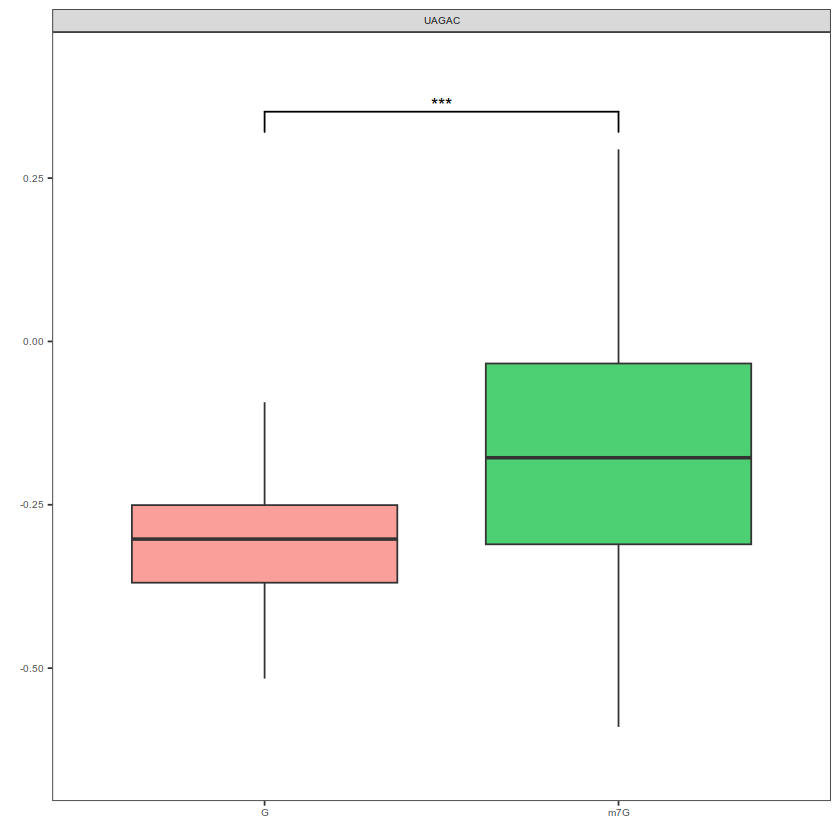

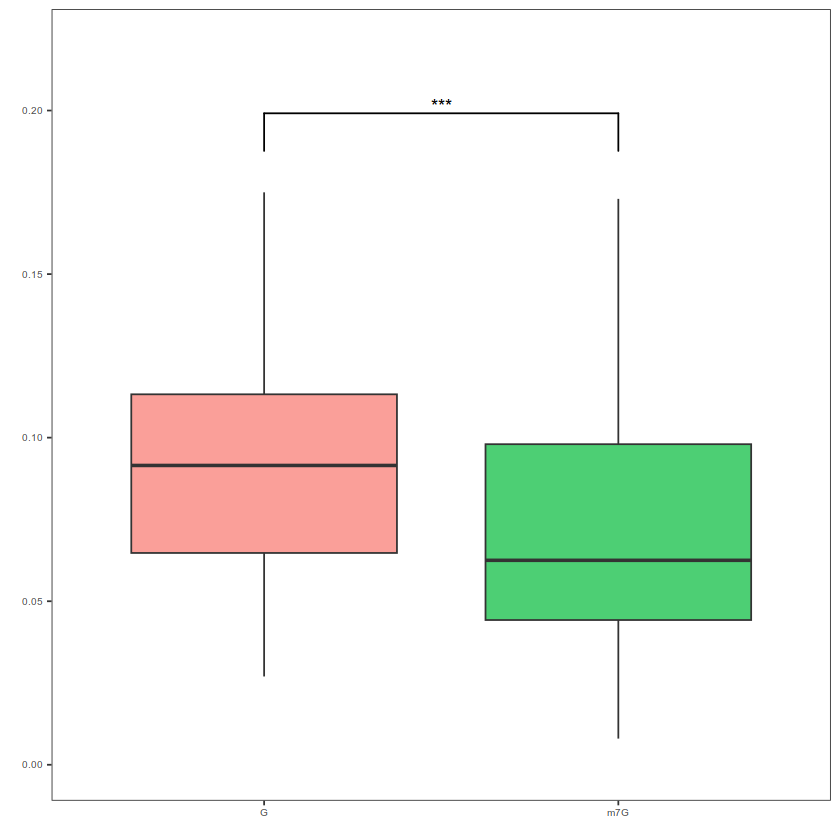

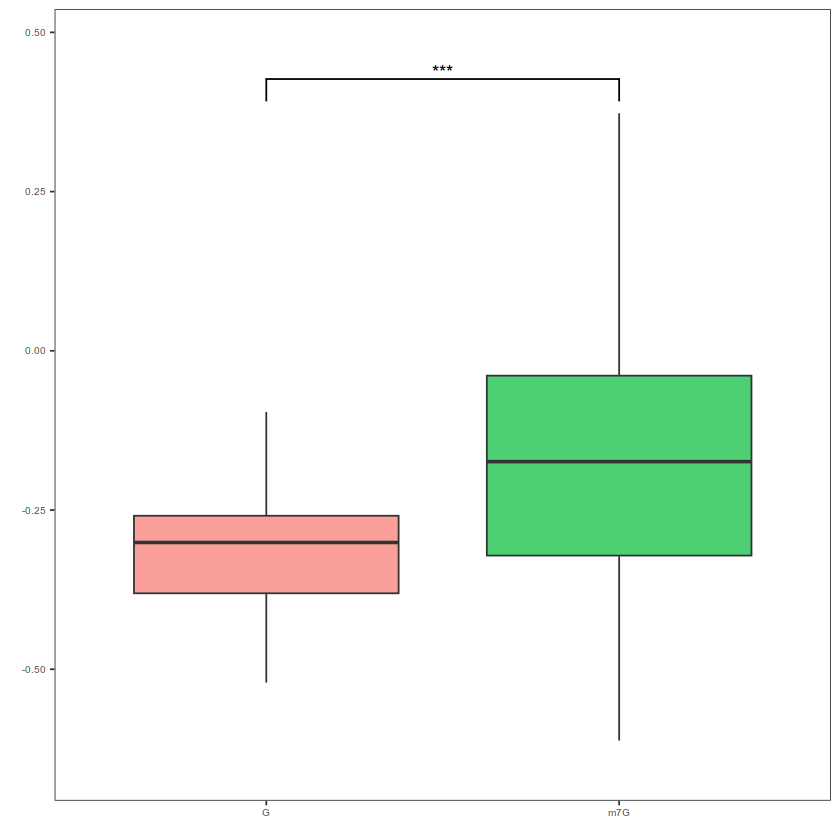

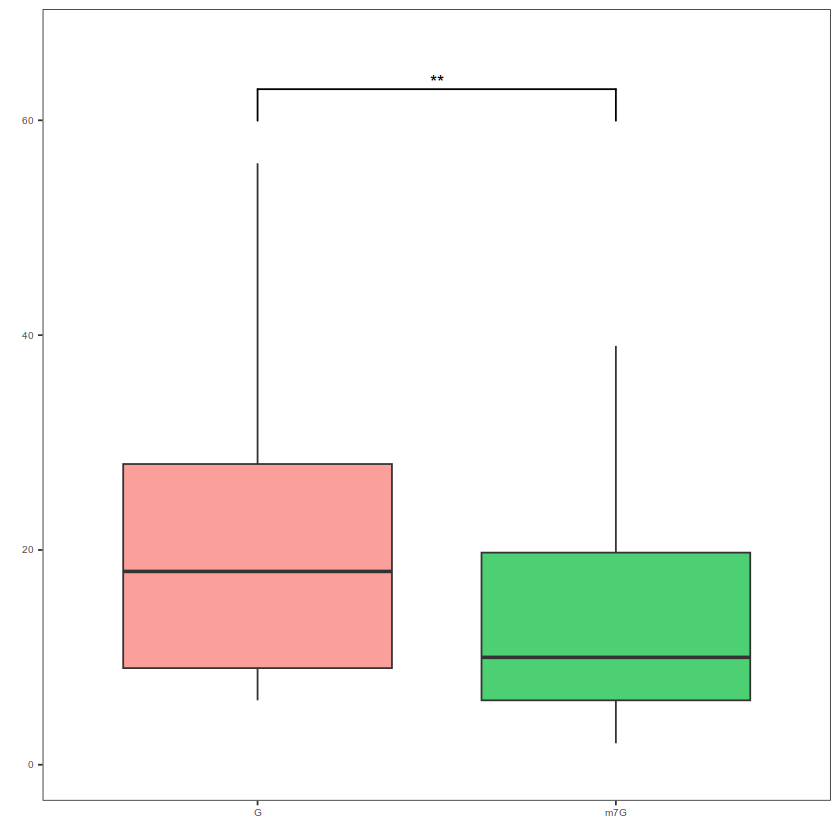

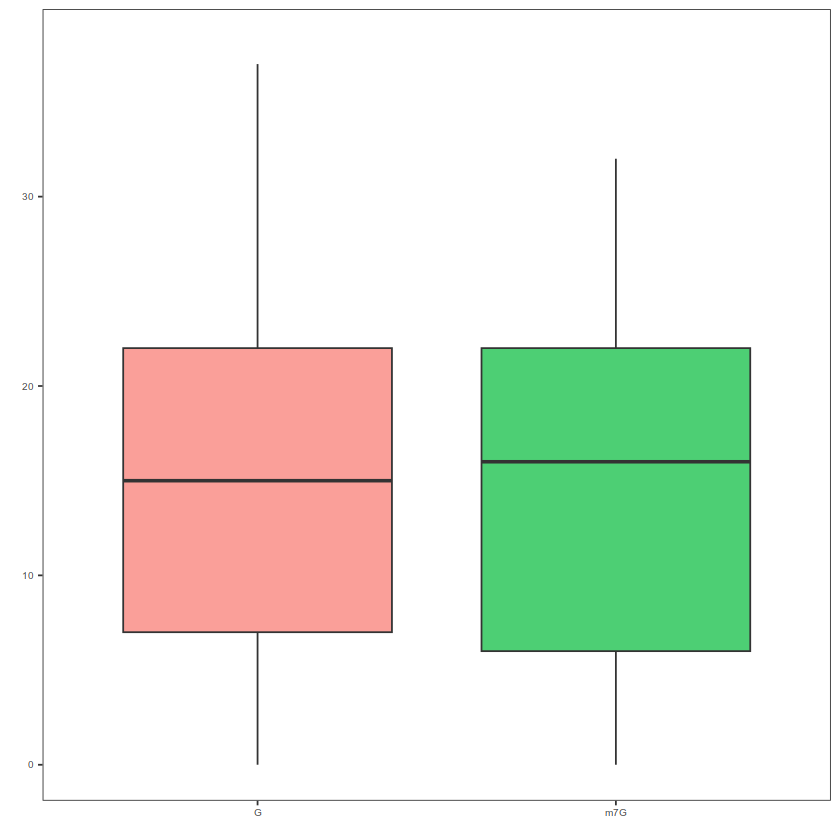

In [2]:
#R code
#event leavel features

library(ggplot2)
library(ggsignif)
library(extrafont)
options(warn = -1)

# "#F8766D" "#00BA38" "#619CFF"

#mean
data=read.csv("data/event_level_features_G_mean.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("G", "m7G")),
        map_signif_level = TRUE,
        y_position = 0.3,vjust = 0.5
      )+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(-0.65,0.42))+
      facet_wrap(vars(sequence))+
      scale_fill_manual(values=c("#F8766D","#00BA38"))
        
ggsave("figure/figure_1a_event_level_features_G_mean.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)


#std
data=read.csv("data/event_level_features_G_std.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("G", "m7G")),
        map_signif_level = TRUE,
        y_position = 0.18,vjust = 0.5
      )+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(0,0.22))+
      scale_fill_manual(values=c("#F8766D","#00BA38"))
        
ggsave("figure/figure_1a_event_level_features_G_std.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)


#median
data=read.csv("data/event_level_features_G_median.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("G", "m7G")),
        map_signif_level = TRUE,
        y_position = 0.37,vjust = 0.5
      )+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(-0.65,0.48))+
      scale_fill_manual(values=c("#F8766D","#00BA38"))
        
ggsave("figure/figure_1a_event_level_features_G_median.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)


#dwell
data=read.csv("data/event_level_features_G_length.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("G", "m7G")),
        map_signif_level = TRUE,
        y_position = 58,vjust = 0.5
      )+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(0,67))+
      scale_fill_manual(values=c("#F8766D","#00BA38"))
        
ggsave("figure/figure_1a_event_level_features_G_length.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)



#base_quality
data=read.csv("data/event_level_features_G_base_quality.csv", encoding='utf-8')

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(0,38))+
      scale_fill_manual(values=c("#F8766D","#00BA38"))
        
ggsave("figure/figure_1a_event_level_features_G_base_quality.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)


### Plot data preparation of U/psU

In [2]:
#python code

from scipy import interpolate
import traceback
import pandas as pd
import re
import numpy as np
from statsmodels import robust


def interp(x):
    """
    Interpolates a given list of values using linear interpolation.

    Args:
        x (list): List of values to be interpolated.

    Returns:
        list: Interpolated values.

    """
    l=len(x)
    y=x
    x=np.linspace(0,l-1,l)
    f=interpolate.interp1d(x,y,kind='slinear')
    x_new=np.linspace(0,l-1,100)
    y_new=f(x_new)
    y_new=np.around(y_new,4)
    return y_new.tolist()

ref_file="/home/wuyou/Projects/paper/data/ELIGOS.fasta"
ref_dict={}
with open(ref_file) as f:
    for line in f:
        line=line.rstrip()
        if ">" in line:
            chr=line[1:]
        else:
            seq=line
            ref_dict[chr]=seq


ref_chr="U2"
site=254
normalize="median_mad"

motif=ref_dict[chr][site-2:site+3]
print("motif:",motif)


X_mean=[]
X_std=[]
X_median=[]
X_length=[]
X_base_quality=[]
Y=[]

signal_files=["/home/wuyou/Projects/paper/ELIGOS_normalU/normalU.signal.tsv",
              "/home/wuyou/Projects/paper/ELIGOS_psU/psU.signal.tsv"]

label_dict={0:"U",1:"  Ψ "}

for k,signal_file in enumerate(signal_files):
    with open(signal_file) as f:
        count=0
        for line in f:
            line=line.rstrip()
            chr=line.split("\t")[1]
            start=int(line.split("\t")[2])
            seq=line.split("\t")[3]
            signal_string=line.split("\t")[6]
            base_quality_list=line.split("\t")[4].split("|")
            raw_signal=[base_signal_string.split("*") for base_signal_string in signal_string.split("|")]  

            full_length_signal=np.array([x for x in re.split('\*|\|',signal_string)],dtype=int)   #for normlization
            uniq_arr=np.unique(full_length_signal)
            full_length_mean=np.mean(full_length_signal)
            full_length_std=np.std(full_length_signal)

            if start > site or start+len(seq)-3<site or chr != ref_chr:
                continue
            kmer_raw_signal=raw_signal[site-(start-1)-2:site-(start-1)+3]
            kmer_sequence=seq[site-(start-1)-2:site-(start-1)+3]
            if len(kmer_raw_signal)==0:
                continue
            kmer_raw_signal=[np.array(x,dtype=float) for x in kmer_raw_signal]

            if normalize=="zscore":  
                kmer_raw_signal=[(x-full_length_mean)/full_length_std for x in kmer_raw_signal]     #z-score scaling
            elif normalize=="median_mad":  
                kmer_raw_signal = [(x - np.median(uniq_arr)) / float(robust.mad(uniq_arr)) for x in kmer_raw_signal]

            mean=[np.round(np.mean(x),3) for x in kmer_raw_signal]
            std=[np.round(np.std(x),3) for x in kmer_raw_signal]
            median=[np.round(np.median(x),3) for x in kmer_raw_signal]
            length=[len(x) for x in kmer_raw_signal]
            kmer_base_quality=base_quality_list[site-(start-1)-2:site-(start-1)+3]


            x=[]

            if len(kmer_raw_signal) != 5:
                continue

            for i in range(5):                                 #resample to 500 points

                kmer_raw_signal[i]=interp(np.array(kmer_raw_signal[i],dtype=float))
                x.extend(kmer_raw_signal[i])
            X_mean.append(mean)
            X_std.append(std)
            X_median.append(median)
            for i in range(len(length)):
                if length[i]>150:
                    length[i]=150
            X_length.append(length)
            X_base_quality.append(kmer_base_quality)
            Y.append(label_dict[k])
            count+=1
            if count>100:
                break
            
print("data length:",len(Y))

#save data
data=X_mean
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data["sequence"]=[motif]*len(Y)
data=pd.melt(data,id_vars=["label","sequence"])
data.to_csv("data/event_level_features_U_mean.csv")

data=X_std
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_U_std.csv")

data=X_median
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_U_median.csv")

data=X_length
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_U_length.csv")

data=X_base_quality
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   
#X_mean.columns=["-2","-1","0","1","2"]
data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_U_base_quality.csv")


motif: CATTC
data length: 202


### Boxplot of U/psU

Registering fonts with R



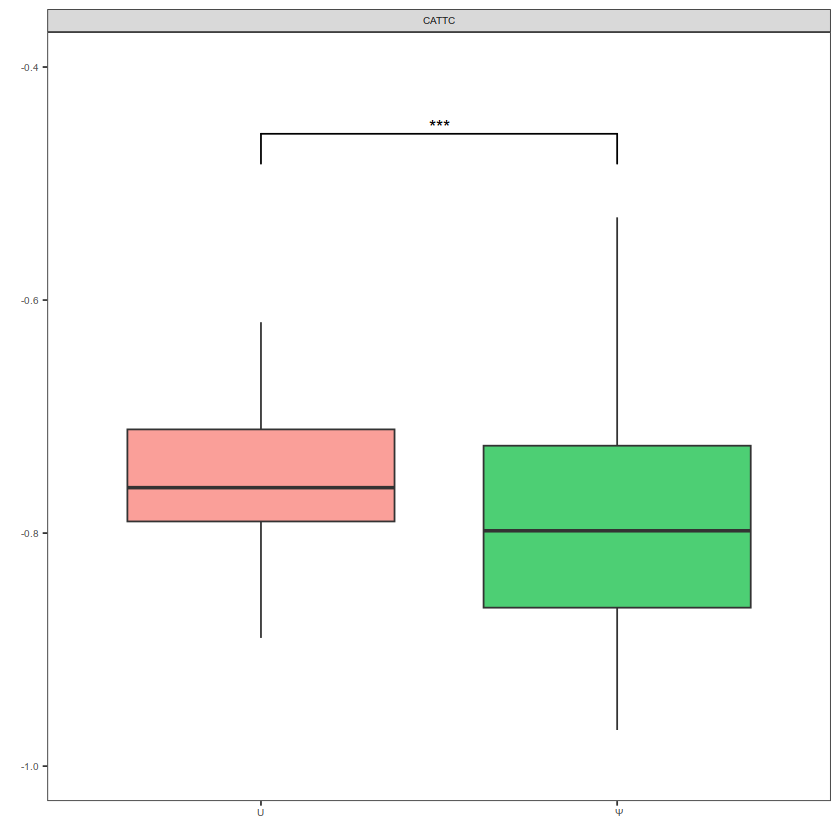

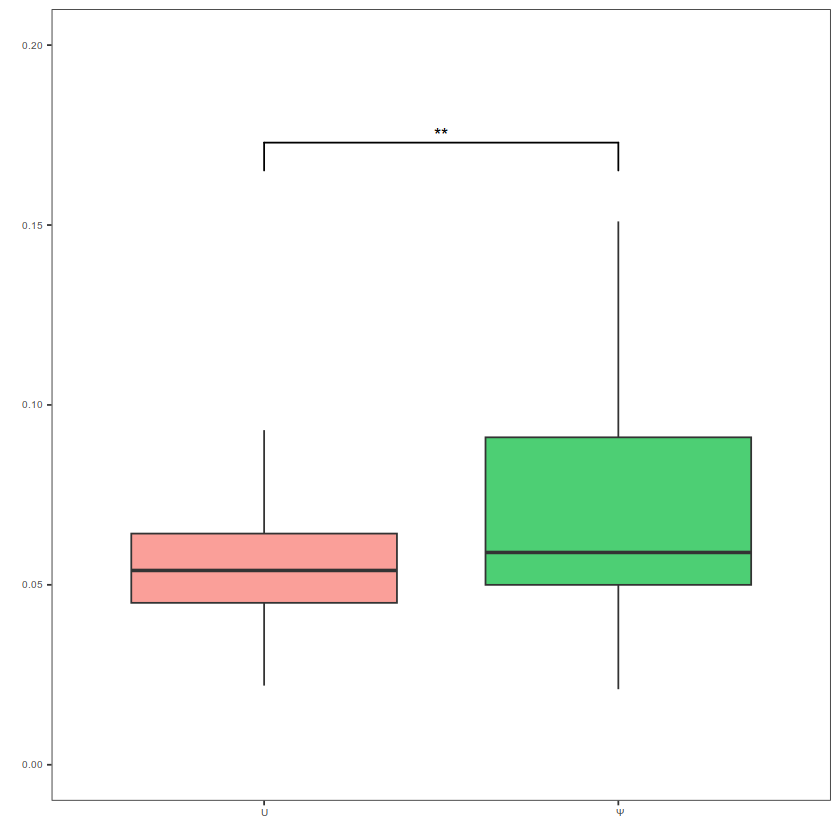

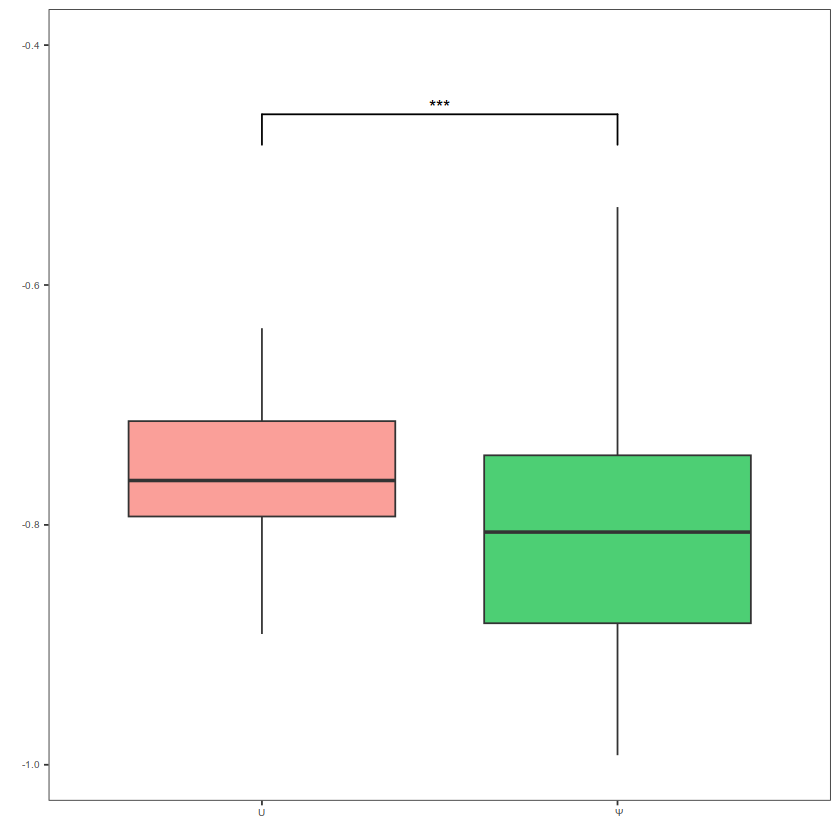

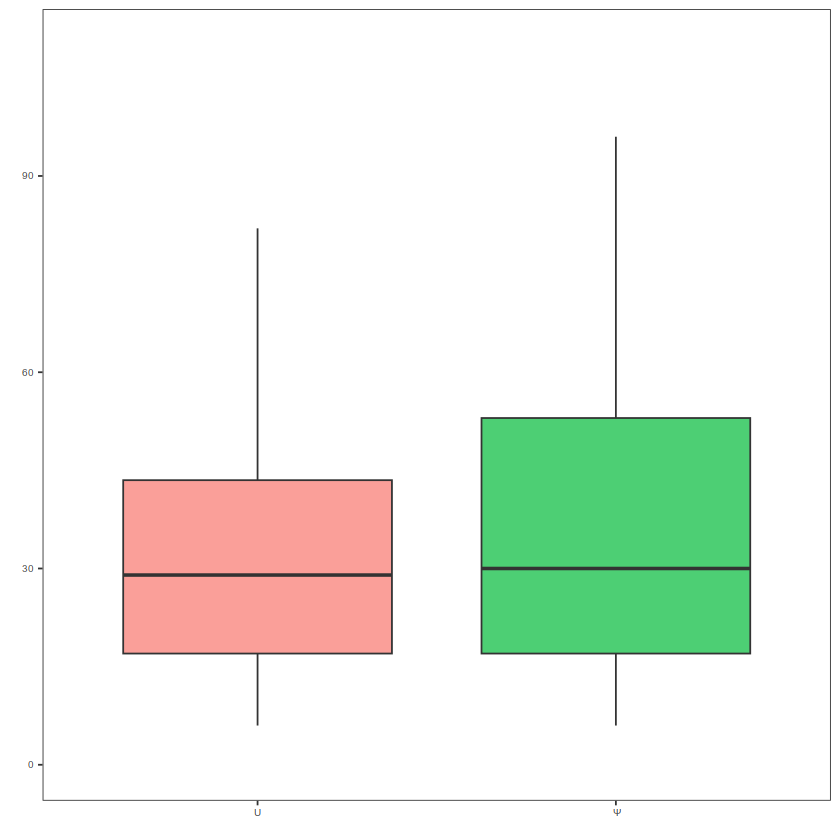

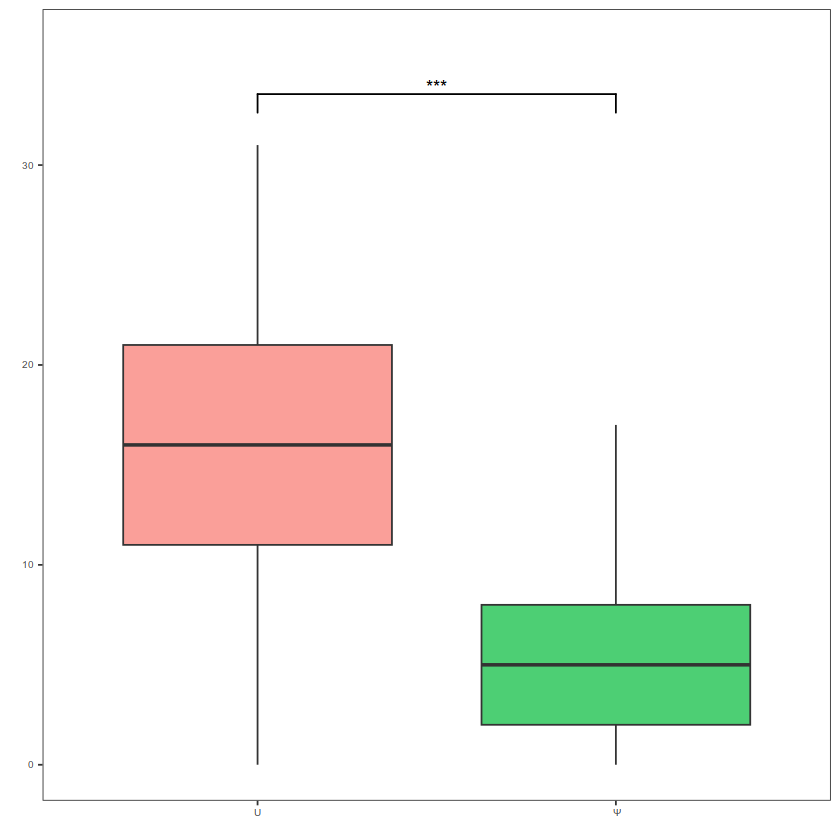

In [1]:
#R code

library(ggplot2)
library(ggsignif)
library(extrafont)
options(warn = -1)
pdf.options(encoding='CP1253.enc')


# "#F8766D" "#00BA38" "#619CFF"

#mean
data=read.csv("data/event_level_features_U_mean.csv", encoding='utf-8')

# I reorder the groups order : I change the order of the factor data$names
data$label <- factor(data$label , levels=c("U","  Ψ "))

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("U", "  Ψ ")),
        map_signif_level = TRUE,
        y_position = -0.50, vjust = 0.5
      )+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(-1,-0.4))+
      facet_wrap(vars(sequence))+
      scale_fill_manual(values=c("#F8766D","#00BA38"))
        
ggsave("figure/figure_1a_event_level_features_U_mean.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)


#std
data=read.csv("data/event_level_features_U_std.csv", encoding='utf-8')

# I reorder the groups order : I change the order of the factor data$names
data$label <- factor(data$label , levels=c("U","  Ψ "))

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("U", "  Ψ ")),
        map_signif_level = TRUE,
        y_position = 0.16, vjust = 0.5
      )+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(0,0.2))+
      #facet_wrap(vars(sequence))+
      scale_fill_manual(values=c("#F8766D","#00BA38"))
        
ggsave("figure/figure_1a_event_level_features_U_std.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)


#median
data=read.csv("data/event_level_features_U_median.csv", encoding='utf-8')

# I reorder the groups order : I change the order of the factor data$names
data$label <- factor(data$label , levels=c("U","  Ψ "))

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("U", "  Ψ ")),
        map_signif_level = TRUE,
        y_position = -0.5, vjust = 0.5
      )+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(-1,-0.4))+
      #facet_wrap(vars(sequence))+
      scale_fill_manual(values=c("#F8766D","#00BA38"))
        
ggsave("figure/figure_1a_event_level_features_U_median.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)



#dwell
data=read.csv("data/event_level_features_U_length.csv", encoding='utf-8')

# I reorder the groups order : I change the order of the factor data$names
data$label <- factor(data$label , levels=c("U","  Ψ "))

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
 

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(0,110))+
      #facet_wrap(vars(sequence))+
      scale_fill_manual(values=c("#F8766D","#00BA38"))
        
ggsave("figure/figure_1a_event_level_features_U_length.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)



#baseq quality
data=read.csv("data/event_level_features_U_base_quality.csv", encoding='utf-8')

# I reorder the groups order : I change the order of the factor data$names
data$label <- factor(data$label , levels=c("U","  Ψ "))

ggplot(data, aes(x = label, y = value, group=label, fill=label)) +
    geom_boxplot(outlier.shape = NA,alpha=0.7) +# using `ggsignif` to display comparison of interest
    #geom_violin()+
    geom_signif(
        comparisons = list(c("U", "  Ψ ")),
        map_signif_level = TRUE,
        y_position = 32, vjust = 0.5
      )+

    theme_bw()+
    theme(
            #legend.background = element_rect(fill = "white", size = 1, colour = "white"),
            strip.text = element_text(size=6),
            #panel.border=element_rect(color=black, size=1),
            legend.position = "none",

            #panel.grid.major = element_line(colour = "grey70", size = 0.1,alpha=0.3),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.title= element_text( size = 6),
            axis.text= element_text( size = 6)
    )+
      labs(y = "",x = "")+
      ylim(c(0,36))+
      #facet_wrap(vars(sequence))+
      scale_fill_manual(values=c("#F8766D","#00BA38"))
        
ggsave("figure/figure_1a_event_level_features_U_base_quality.pdf", width = 4, height = 3.6, units = "cm",device = 'pdf', dpi = 600)


